In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import itertools
import  seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.python.ops.gen_batch_ops import batch
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
IMAGE_SIZE = 236
BATCH_SIZE = 32
EPOCHS = 25
CHANNELS = 3

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Oabo Nwako/Desktop/Study files/Business Intelligence and Data Analytics/Practise/BrainTumorDetection/Training',
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    shuffle = True,
    batch_size = BATCH_SIZE,
)

Found 2870 files belonging to 4 classes.


In [4]:
class_names = train_data.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [5]:
len(train_data)

90

In [6]:
actual_size = len(train_data) * 32
actual_size

2880

In [7]:
#Take shape of the first image
for image_batch, label_batch in train_data.take(1):
    print(image_batch[0].shape, class_names[label_batch[0]])

(236, 236, 3) pituitary_tumor


In [8]:
class_names[label_batch[2]]

'no_tumor'

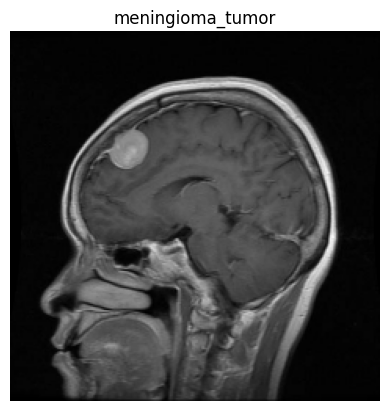

In [9]:
for image_batch, label_batch in train_data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')

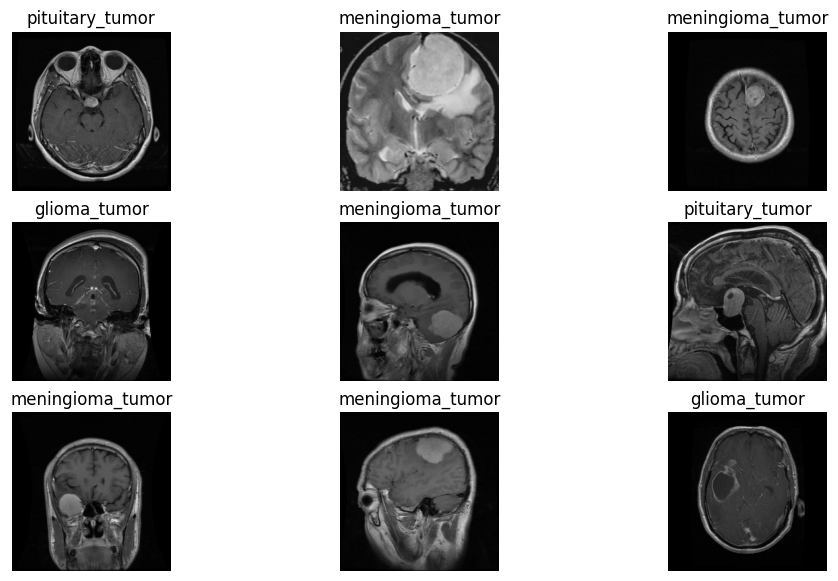

In [10]:
#Display 9 MRI images
plt.figure(figsize=(12,7))

for image_batch, label_batch in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Testing dataset

In [11]:
#loading test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Oabo Nwako/Desktop/Study files/Business Intelligence and Data Analytics/Practise/BrainTumorDetection/Testing',
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    shuffle = True,
    batch_size = BATCH_SIZE,
)

Found 394 files belonging to 4 classes.


In [12]:
#See classes
ttclass_names = test_data.class_names
ttclass_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [13]:
#actual length = len of test_data * batch size
x = len(test_data) * BATCH_SIZE
x

416

In [14]:
#shape of first image
for image_batch, label_batch in test_data.take(1):
    print(image_batch[0].shape, ttclass_names[label_batch[0]])

(236, 236, 3) glioma_tumor


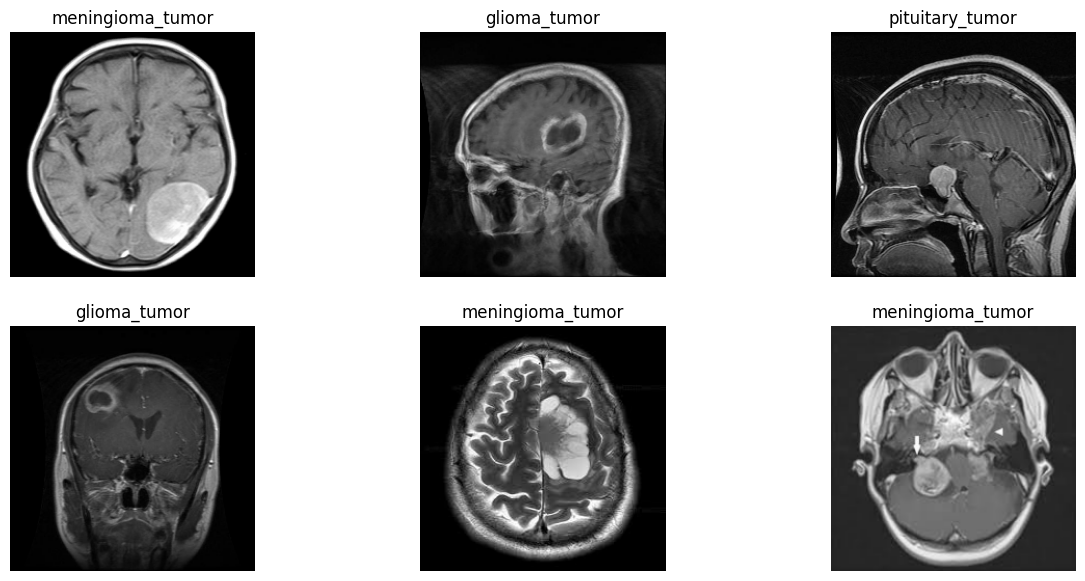

In [15]:
#First 6 images
plt.figure(figsize=(15,7))

for image_batch, label_batch in test_data.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(ttclass_names[label_batch[i]])
        plt.axis('off')

## Train Test Split

In [16]:
# a function to create for validation split
def get_dataset_partitions(train, val_split=0.2, train_split=0.8, shuffle=True, shuffle_size=10000):
    ds_size = len(train)
    if shuffle:
        ds = train.shuffle(shuffle_size, seed=15)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds
        

In [17]:
#create validation set from the dataset
train_ds, val_ds = get_dataset_partitions(train_data)
test_ds = test_data

In [18]:
print(len(train_ds), len(val_ds), len(test_ds))

72 18 13


## Preprocessing

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#resizing and scaling
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) #ensures pixel value is 0-1,
])

In [21]:
#data augmentation
data_augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

## Build Model

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_rescale,
    data_augment,
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 236, 236, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 236, 236, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 234, 234, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 117, 117, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 115, 115, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 57, 57, 64)         0         
 2D)                                                  

In [24]:
#optimisation
model.compile (
    optimizer = 'Adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

## Train Model

### Model 1

In [25]:
#Define early stopping
early_stopping = EarlyStopping(monitor = "loss", patience=5, min_delta=0, mode="auto", restore_best_weights = True)
checkpoint = ModelCheckpoint('best_model.h5', monitor="loss", save_best_only = True)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    verbose= 1,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping,checkpoint]
)

Epoch 1/25
72/72 [==============================] - 272s 3s/step - loss: 1.3272 - accuracy: 0.3391 - val_loss: 1.2524 - val_accuracy: 0.3438
Epoch 2/25
72/72 [==============================] - 159s 2s/step - loss: 1.1621 - accuracy: 0.4738 - val_loss: 1.0657 - val_accuracy: 0.5590
Epoch 3/25
72/72 [==============================] - 160s 2s/step - loss: 1.0448 - accuracy: 0.5462 - val_loss: 0.9696 - val_accuracy: 0.5747
Epoch 4/25
72/72 [==============================] - 165s 2s/step - loss: 0.9141 - accuracy: 0.6142 - val_loss: 0.7993 - val_accuracy: 0.7031
Epoch 5/25
72/72 [==============================] - 163s 2s/step - loss: 0.9283 - accuracy: 0.5950 - val_loss: 0.9043 - val_accuracy: 0.6632
Epoch 6/25
72/72 [==============================] - 161s 2s/step - loss: 0.8474 - accuracy: 0.6495 - val_loss: 0.8520 - val_accuracy: 0.6632
Epoch 7/25
72/72 [==============================] - 164s 2s/step - loss: 0.7957 - accuracy: 0.6713 - val_loss: 0.7142 - val_accuracy: 0.7031
Epoch 8/25
72

In [27]:
#display train, val,test loss and train,val, test, accuracy
train_scores = model.evaluate(train_ds)
val_scores = model.evaluate(val_ds)
scores = model.evaluate(test_ds)
scores

13/13 [==============================] - 9s 427ms/step - loss: 2.6619 - accuracy: 0.5330


[2.661869525909424, 0.5329949259757996]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
def plot_evaluate(accuracy, validation_accuracy, loss, validation_loss, epochs):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(range(epochs), acc, label='Accuraccy')
    plt.plot(range(epochs), val_acc, label='Val_Accuraccy')
    plt.xlabel("epochs")
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")

    plt.subplot(1,2,2)
    plt.plot(range(epochs), loss, label='Loss')
    plt.plot(range(epochs), val_loss, label='Val_Loss')
    plt.xlabel("epochs")
    plt.legend(loc='lower right')
    plt.title("Training and Validation Loss")
    plt.show()

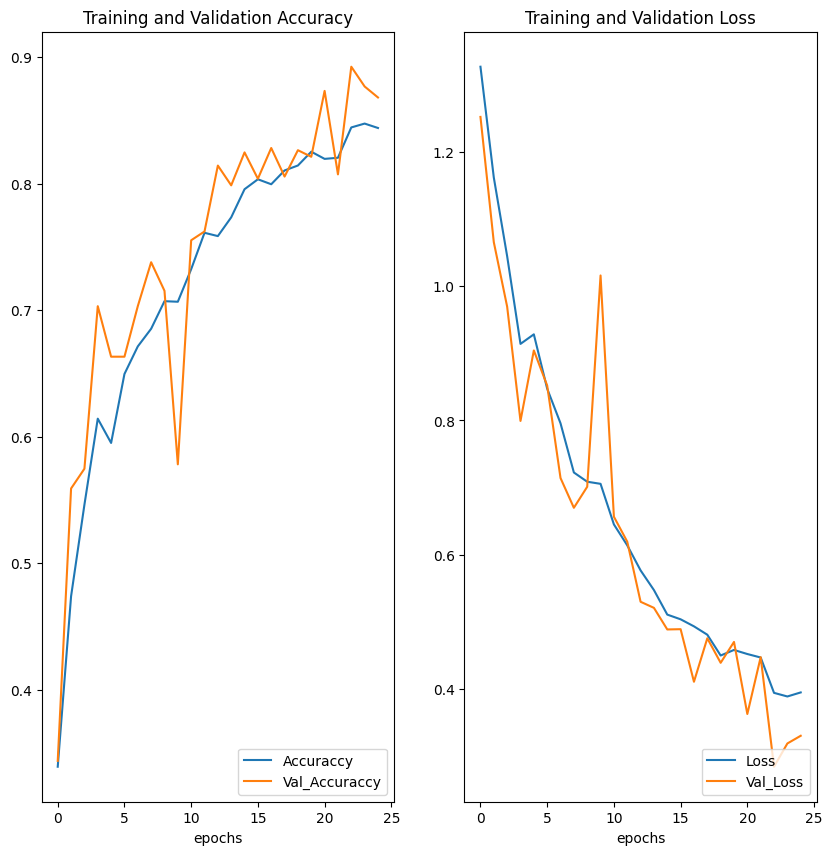

In [30]:
plot_evaluate(acc, val_acc, loss, val_loss, EPOCHS)

In [31]:
## function to predict images

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = ttclass_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


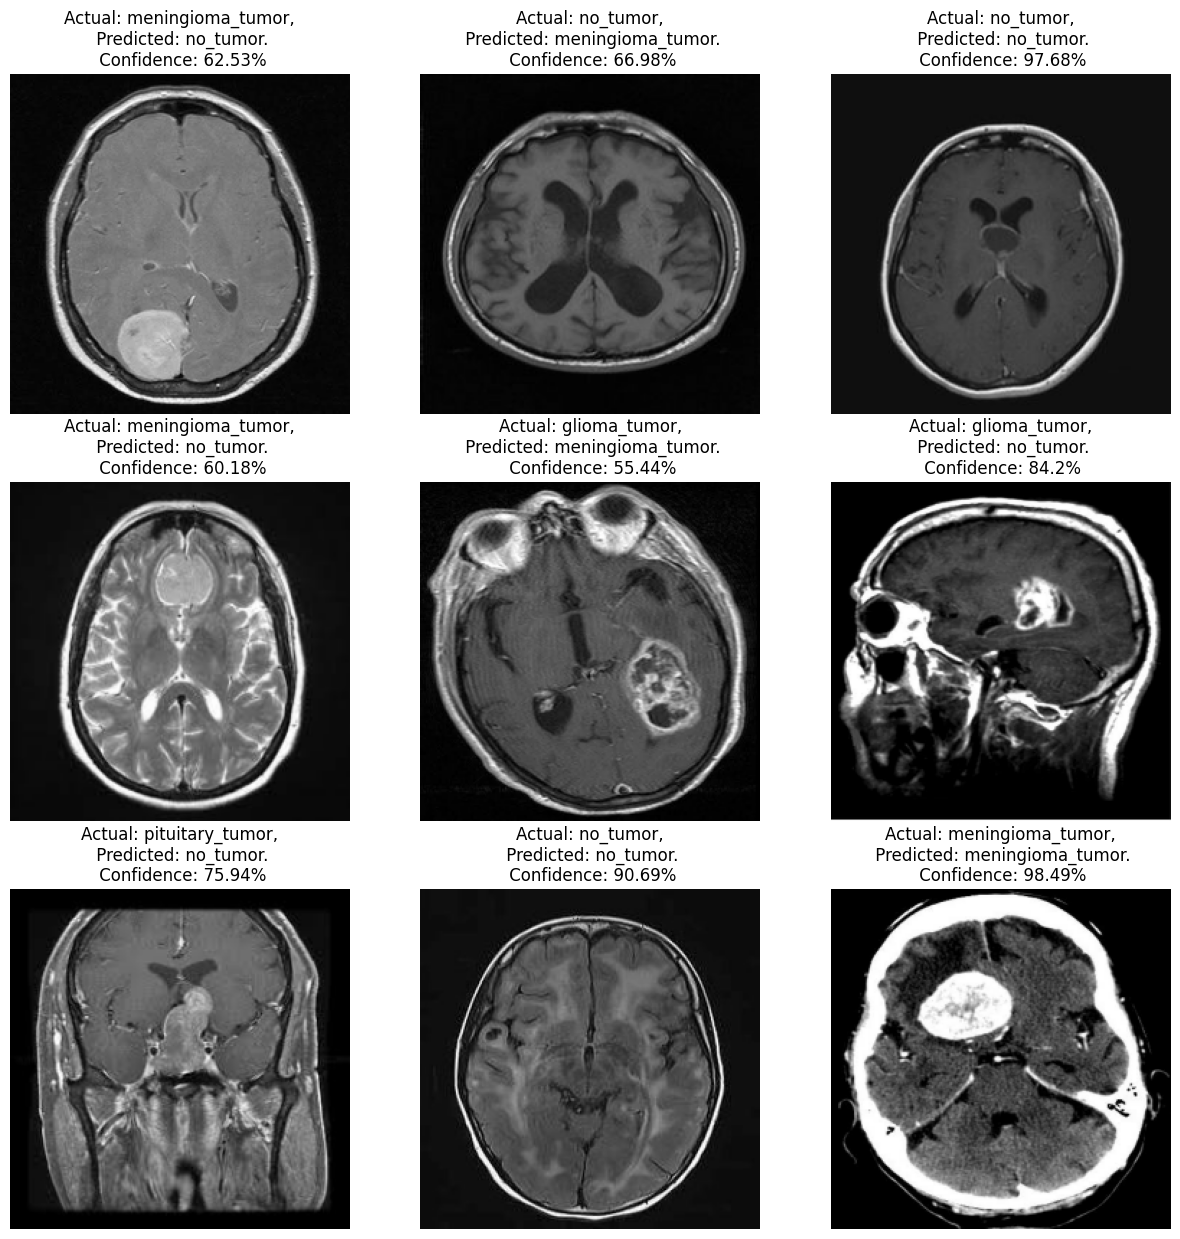

In [32]:
#Evaluate confidence of model on test set
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Confusion Matrix for Model 1

In [33]:
def predict1(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = ttclass_names[np.argmax(predictions[0])]
    #confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class

In [34]:
aclass = []
pclass = []
for images, labels in test_ds:
    for i in range(10):
        #ax = plt.subplot(3,3, i + 1)
        #plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class = predict1(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        if actual_class == 'glioma_tumor':
            aclass.append(0)
        elif actual_class == 'meningioma_tumor':
            aclass.append(1)
        elif actual_class == 'no_tumor':
            aclass.append(2)
        elif actual_class == 'pituitary_tumor':
            aclass.append(3)
        
        if predicted_class == 'glioma_tumor':
            pclass.append(0)
        elif predicted_class == 'meningioma_tumor':
            pclass.append(1)
        elif predicted_class == 'no_tumor':
            pclass.append(2)
        elif predicted_class == 'pituitary_tumor':
            pclass.append(3)
        
        cm = confusion_matrix(np.array(aclass), np.array(pclass))

1/1 [==============================] - 0s 41ms/step


Text(0.5, 1.0, 'Confusion Matrix for CNN model1')

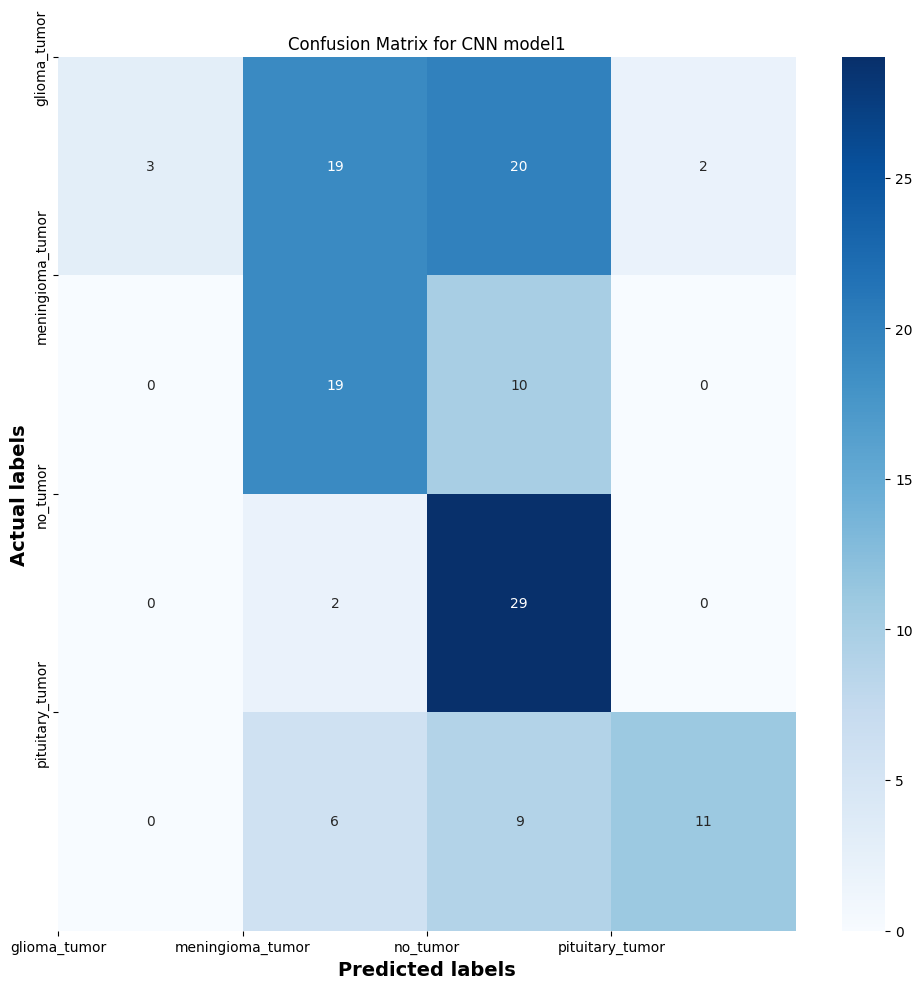

In [35]:
#plotting a confusion matrix for CNN Model 1
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels", fontsize=14, weight='bold')
plt.ylabel("Actual labels", fontsize=14, weight='bold')
tick_marks = np.arange(4)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.title("Confusion Matrix for CNN model1")


### Model 2

In [36]:
model2 = models.Sequential([
    resize_rescale,
    data_augment,
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(n_classes, activation='softmax')
])

model2.build(input_shape = input_shape)

In [37]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 236, 236, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 236, 236, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 234, 234, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 117, 117, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 115, 115, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 57, 57, 64)         0         
 2D)                                                  

In [38]:
model2.compile(
    optimizer="adam",
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
    
)

In [39]:
history2 = model2.fit(
    train_ds,
    verbose = 1,
    validation_data = val_ds,
    epochs = 25
)

Epoch 1/25


72/72 [==============================] - 167s 2s/step - loss: 1.3395 - accuracy: 0.3884 - val_loss: 1.2471 - val_accuracy: 0.4375
Epoch 2/25
72/72 [==============================] - 163s 2s/step - loss: 1.1955 - accuracy: 0.4765 - val_loss: 1.2220 - val_accuracy: 0.4948
Epoch 3/25
72/72 [==============================] - 160s 2s/step - loss: 1.1016 - accuracy: 0.5301 - val_loss: 1.0270 - val_accuracy: 0.6007
Epoch 4/25
72/72 [==============================] - 161s 2s/step - loss: 0.9698 - accuracy: 0.6146 - val_loss: 0.9158 - val_accuracy: 0.6632
Epoch 5/25
72/72 [==============================] - 172s 2s/step - loss: 0.9094 - accuracy: 0.6282 - val_loss: 0.8443 - val_accuracy: 0.6632
Epoch 6/25
72/72 [==============================] - 160s 2s/step - loss: 0.8487 - accuracy: 0.6452 - val_loss: 0.7638 - val_accuracy: 0.7083
Epoch 7/25
72/72 [==============================] - 160s 2s/step - loss: 0.8703 - accuracy: 0.6425 - val_loss: 0.7637 - val_accuracy: 0.6927
Epoch 8/25
72/72 [======

In [77]:
#display train, val,test loss and train,val, test, accuracy
train_scores2 = model2.evaluate(train_ds)
val_scores2 = model2.evaluate(val_ds)
scores2 = model2.evaluate(test_ds)
scores2

13/13 [==============================] - 7s 501ms/step - loss: 1.9293 - accuracy: 0.5914


[1.9292805194854736, 0.5913705825805664]

In [41]:
#accuracy
acc = history2.history['accuracy']
val_acc = history.history['val_accuracy']

#losses
loss = history2.history['accuracy']
val_loss = history2.history['val_accuracy']

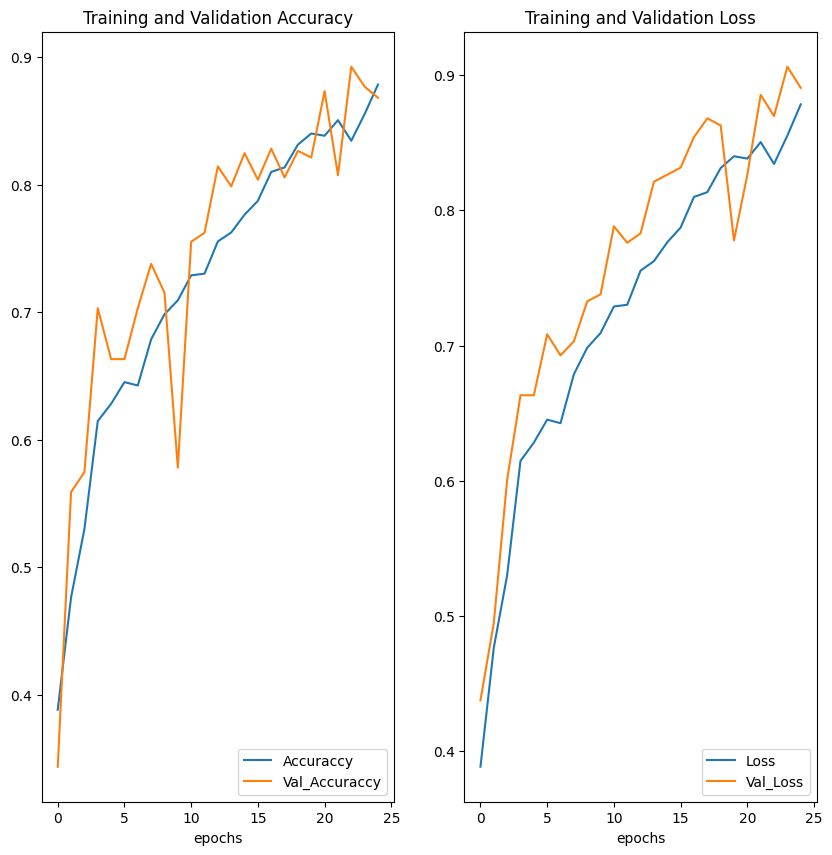

In [42]:
plot_evaluate(acc, val_acc, loss, val_loss, EPOCHS)

#### Confusion Matrix for Model 2

In [43]:
aclass = []
pclass = []
for images, labels in test_ds:
    for i in range(10):
        #ax = plt.subplot(3,3, i + 1)
        #plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class = predict1(model2, images[i].numpy())
        actual_class = class_names[labels[i]]
        if actual_class == 'glioma_tumor':
            aclass.append(0)
        elif actual_class == 'meningioma_tumor':
            aclass.append(1)
        elif actual_class == 'no_tumor':
            aclass.append(2)
        elif actual_class == 'pituitary_tumor':
            aclass.append(3)
        
        if predicted_class == 'glioma_tumor':
            pclass.append(0)
        elif predicted_class == 'meningioma_tumor':
            pclass.append(1)
        elif predicted_class == 'no_tumor':
            pclass.append(2)
        elif predicted_class == 'pituitary_tumor':
            pclass.append(3)
        
        cm = confusion_matrix(np.array(aclass), np.array(pclass))

1/1 [==============================] - 0s 59ms/step


Text(0.5, 1.0, 'Confusion Matrix for CNN model2')

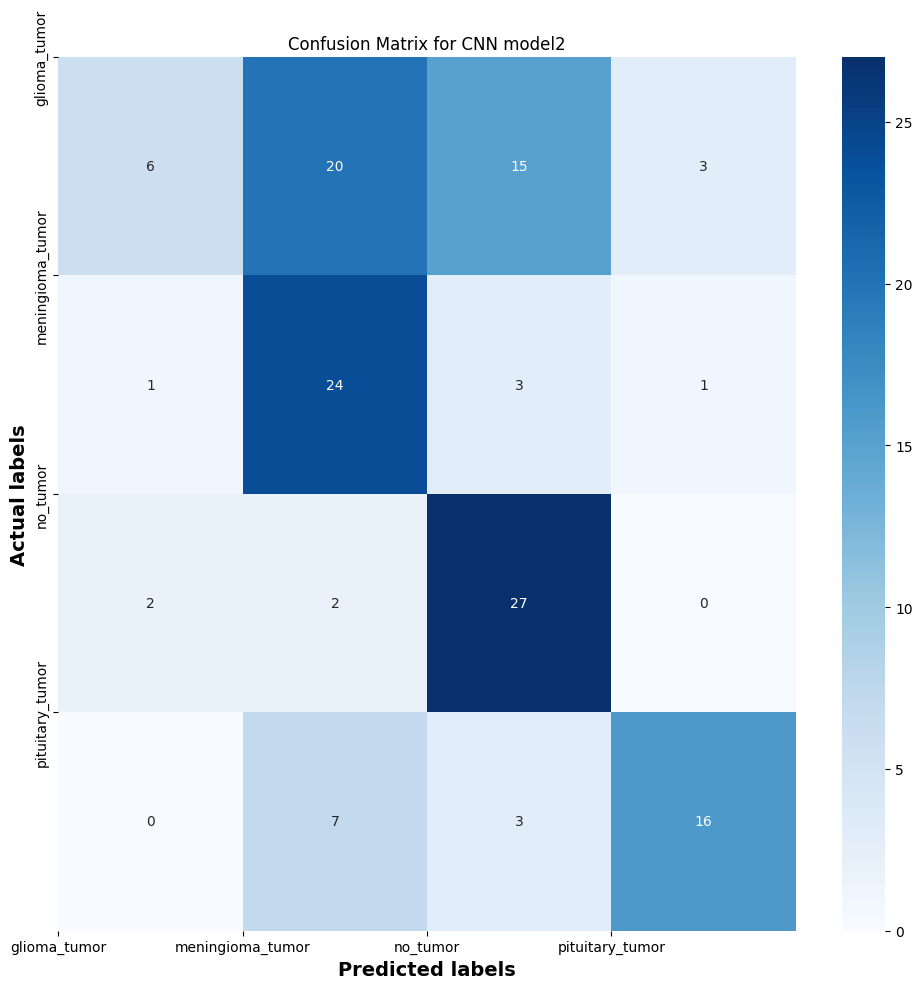

In [44]:
#plotting a confusion matrix for CNN Model 2
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels", fontsize=14, weight='bold')
plt.ylabel("Actual labels", fontsize=14, weight='bold')
tick_marks = np.arange(4)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.title("Confusion Matrix for CNN model2")


1/1 [==============================] - 0s 47ms/step


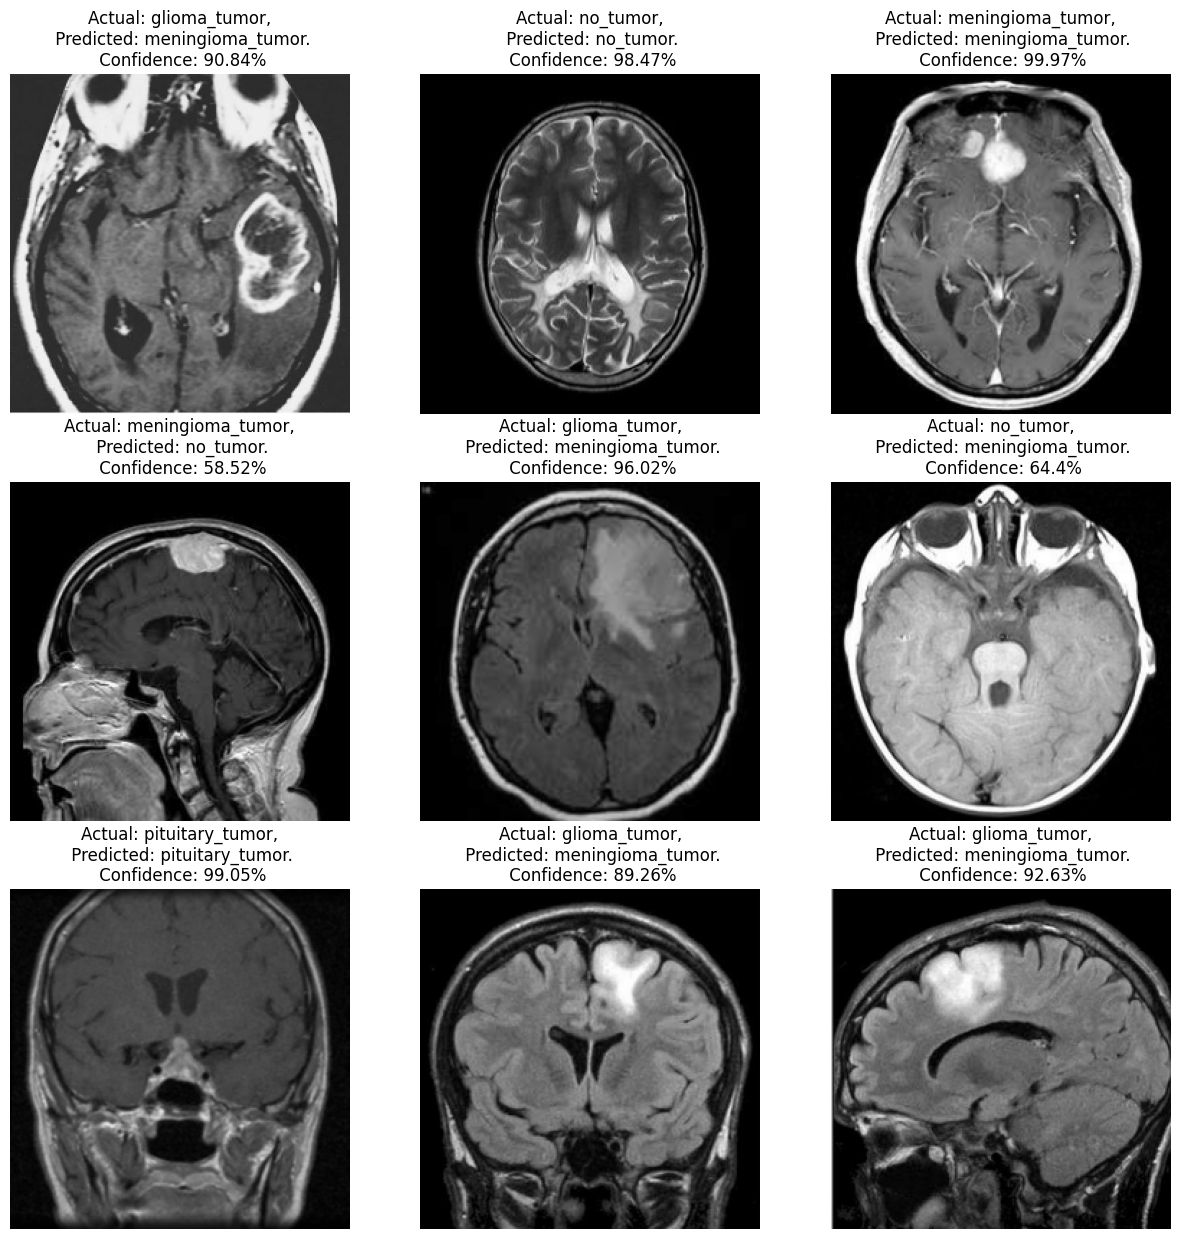

In [45]:
#Evaluate confidence of model on test set
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Model 3

In [46]:
#n_classes = 4
model3 = models.Sequential([
    resize_rescale,
    data_augment,
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(n_classes, activation='softmax')
])

model3.build(input_shape = input_shape)

In [47]:
model3.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [48]:
history3 = model3.fit(
    train_ds,
    verbose=1,
    validation_data = val_ds,
    epochs = 25,
)

Epoch 1/25
72/72 [==============================] - 166s 2s/step - loss: 1.3260 - accuracy: 0.4032 - val_loss: 1.2238 - val_accuracy: 0.5017
Epoch 2/25
72/72 [==============================] - 167s 2s/step - loss: 1.1519 - accuracy: 0.4935 - val_loss: 1.1467 - val_accuracy: 0.5052
Epoch 3/25
72/72 [==============================] - 162s 2s/step - loss: 1.0545 - accuracy: 0.5588 - val_loss: 1.0172 - val_accuracy: 0.5920
Epoch 4/25
72/72 [==============================] - 159s 2s/step - loss: 0.9573 - accuracy: 0.6037 - val_loss: 0.9031 - val_accuracy: 0.6337
Epoch 5/25
72/72 [==============================] - 163s 2s/step - loss: 0.8876 - accuracy: 0.6447 - val_loss: 0.9096 - val_accuracy: 0.6267
Epoch 6/25
72/72 [==============================] - 160s 2s/step - loss: 0.8595 - accuracy: 0.6622 - val_loss: 0.8401 - val_accuracy: 0.6615
Epoch 7/25
72/72 [==============================] - 160s 2s/step - loss: 0.8133 - accuracy: 0.6635 - val_loss: 0.8464 - val_accuracy: 0.6562
Epoch 8/25
72

In [75]:
#display train, val,test loss and train,val, test, accuracy
train_scores3 = model3.evaluate(train_ds)
val_scores3 = model3.evaluate(val_ds)
scores3 = model3.evaluate(test_ds)
scores3

13/13 [==============================] - 6s 457ms/step - loss: 2.7420 - accuracy: 0.6142


[2.7419936656951904, 0.6142131686210632]

In [50]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

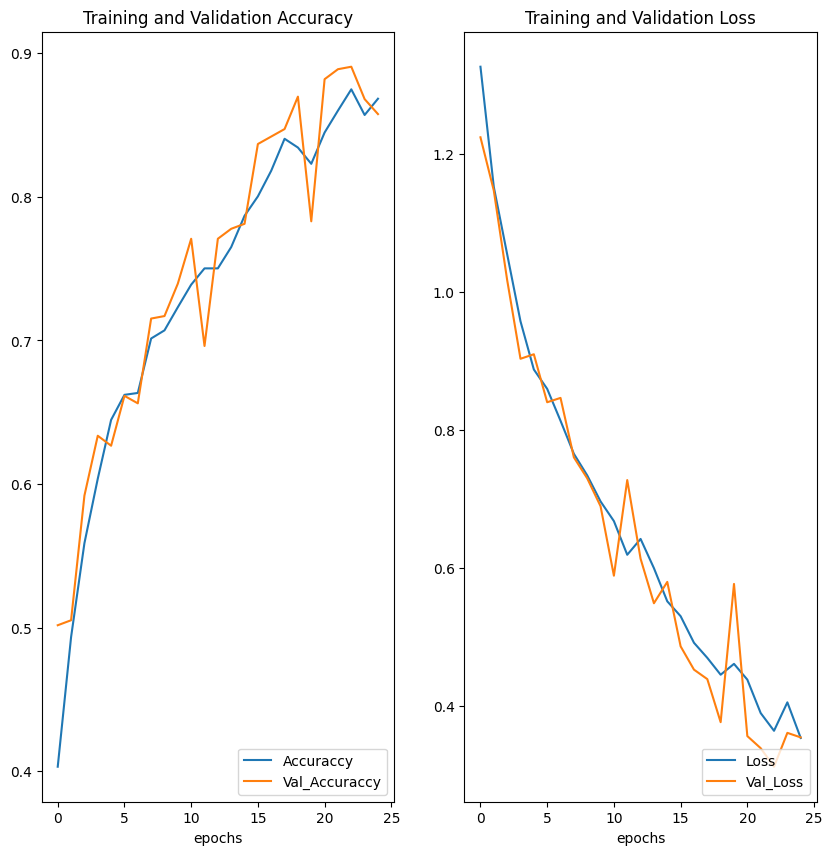

In [51]:
plot_evaluate(acc, val_acc, loss, val_acc, 25)

#### Confusion Matrix for Model 3

In [52]:
aclass = []
pclass = []
for images, labels in test_ds:
    for i in range(10):
        #ax = plt.subplot(3,3, i + 1)
        #plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class = predict1(model3, images[i].numpy())
        actual_class = class_names[labels[i]]
        if actual_class == 'glioma_tumor':
            aclass.append(0)
        elif actual_class == 'meningioma_tumor':
            aclass.append(1)
        elif actual_class == 'no_tumor':
            aclass.append(2)
        elif actual_class == 'pituitary_tumor':
            aclass.append(3)
        
        if predicted_class == 'glioma_tumor':
            pclass.append(0)
        elif predicted_class == 'meningioma_tumor':
            pclass.append(1)
        elif predicted_class == 'no_tumor':
            pclass.append(2)
        elif predicted_class == 'pituitary_tumor':
            pclass.append(3)
        
        cm = confusion_matrix(np.array(aclass), np.array(pclass))

1/1 [==============================] - 0s 57ms/step


Text(0.5, 1.0, 'Confusion Matrix for CNN model3')

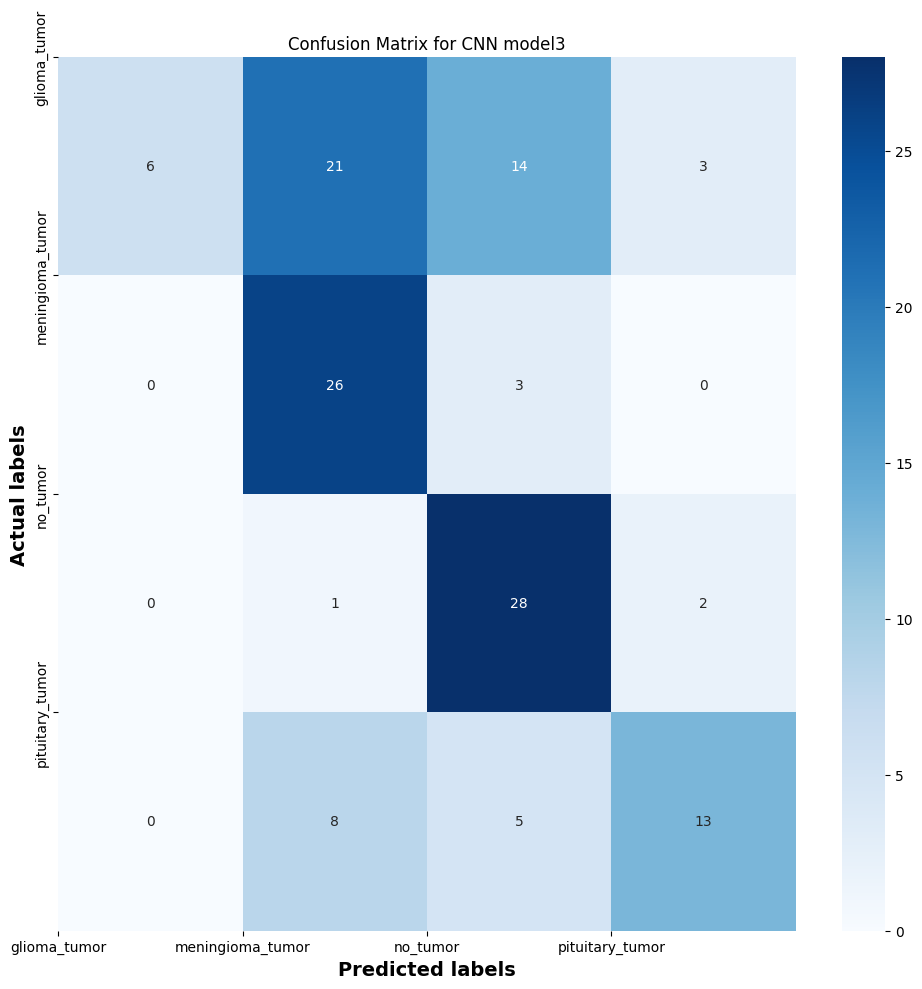

In [53]:
#plotting a confusion matrix for CNN Model 3
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels", fontsize=14, weight='bold')
plt.ylabel("Actual labels", fontsize=14, weight='bold')
tick_marks = np.arange(4)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.title("Confusion Matrix for CNN model3")


1/1 [==============================] - 0s 38ms/step


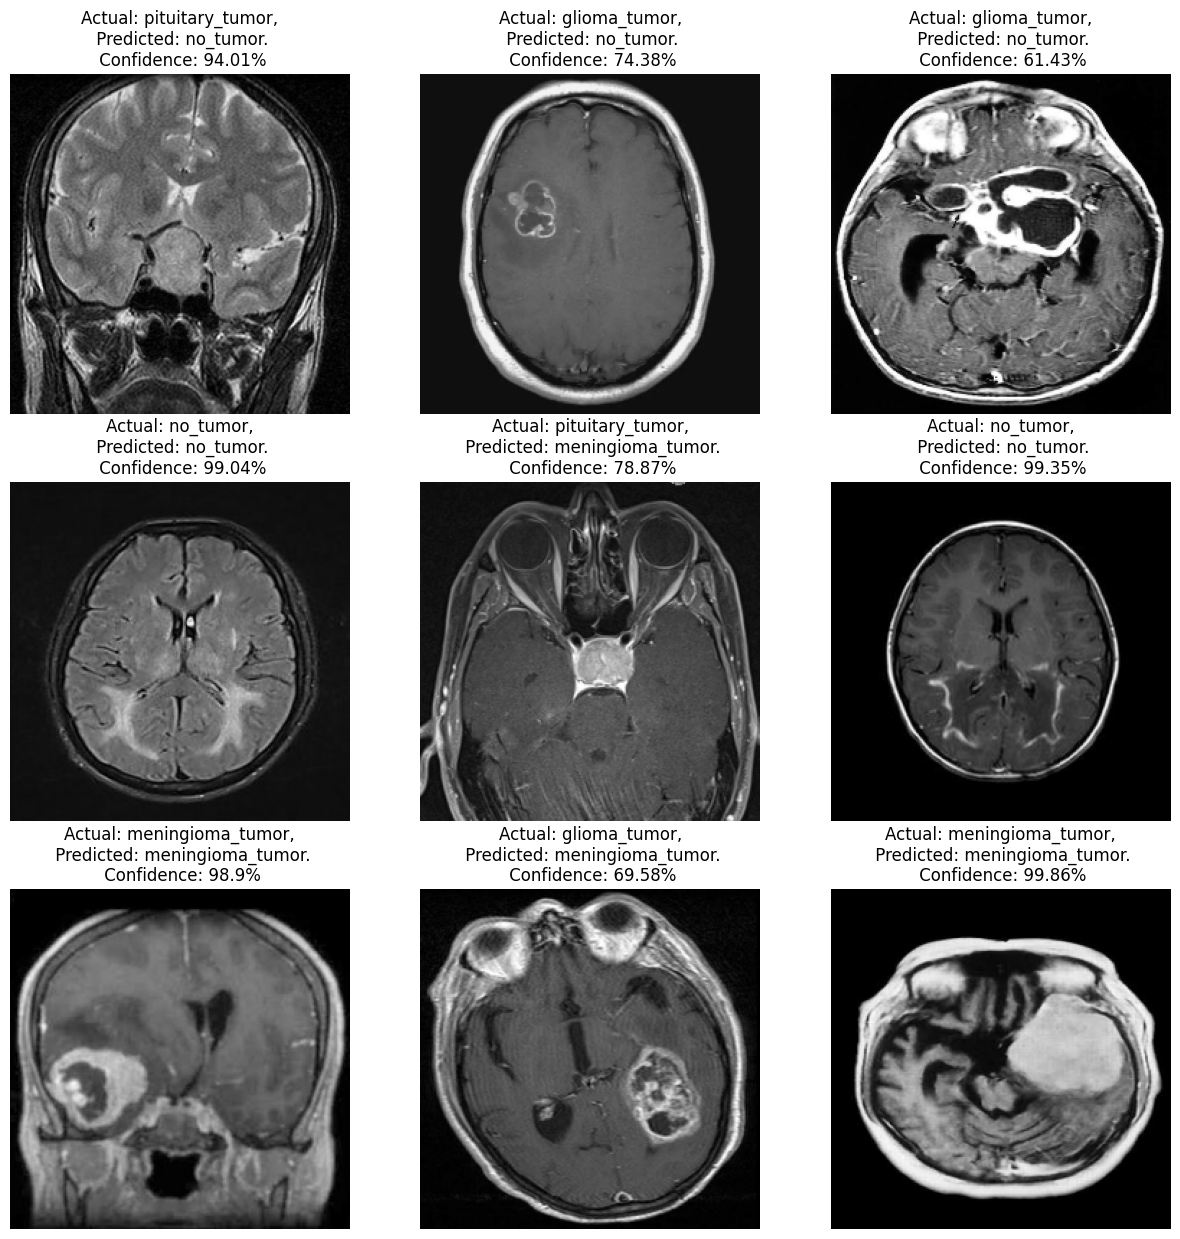

In [54]:
#Evaluate confidence of model on test set
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class, confidence = predict(model3, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Model 4

In [118]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model4 = models.Sequential([
    #Data augmentation
    resize_rescale,
    data_augment,
    
    #feature learning
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    
    #flattening tensors
    layers.Flatten(),
    
    #fully connected layers
    #layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
    layers.Dense(1028, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
    
    #output layer
    layers.Dense(n_classes, activation='softmax')
])

model4.build(input_shape = input_shape)

In [119]:
model4.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [120]:
history4 = model4.fit(
    train_ds,
    verbose = 1,
    epochs = 25,
    validation_data = val_ds,
)

Epoch 1/25
72/72 [==============================] - 191s 3s/step - loss: 1.6861 - accuracy: 0.3915 - val_loss: 1.2471 - val_accuracy: 0.5139
Epoch 2/25
72/72 [==============================] - 166s 2s/step - loss: 1.1709 - accuracy: 0.4987 - val_loss: 1.1484 - val_accuracy: 0.5000
Epoch 3/25
72/72 [==============================] - 169s 2s/step - loss: 1.0552 - accuracy: 0.5562 - val_loss: 1.0353 - val_accuracy: 0.5747
Epoch 4/25
72/72 [==============================] - 165s 2s/step - loss: 0.9699 - accuracy: 0.6103 - val_loss: 0.9304 - val_accuracy: 0.6667
Epoch 5/25
72/72 [==============================] - 167s 2s/step - loss: 0.9242 - accuracy: 0.6303 - val_loss: 1.1717 - val_accuracy: 0.5365
Epoch 6/25
72/72 [==============================] - 167s 2s/step - loss: 0.8750 - accuracy: 0.6395 - val_loss: 0.7836 - val_accuracy: 0.7309
Epoch 7/25
72/72 [==============================] - 166s 2s/step - loss: 0.8440 - accuracy: 0.6609 - val_loss: 0.8349 - val_accuracy: 0.6840
Epoch 8/25
72

In [121]:
#display train, val,test loss and train,val, test, accuracy
train_scores4 = model4.evaluate(train_ds)
val_scores4 = model4.evaluate(val_ds)
scores4 = model4.evaluate(test_ds)
scores4

13/13 [==============================] - 14s 1s/step - loss: 2.3910 - accuracy: 0.5457


[2.3909764289855957, 0.5456852912902832]

In [122]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

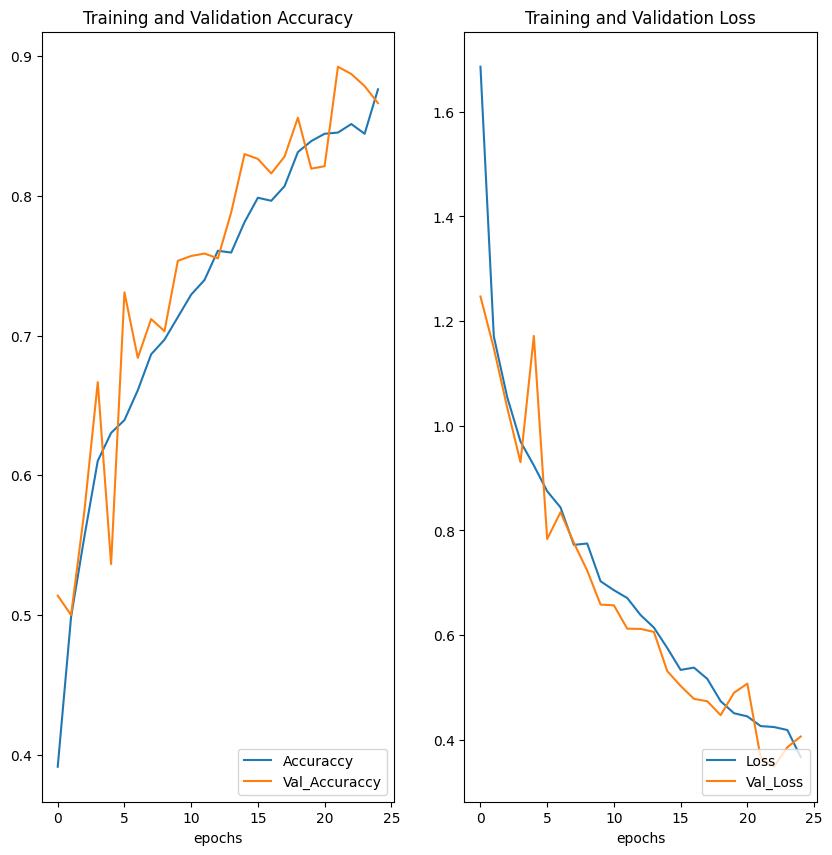

In [123]:
plot_evaluate(acc, val_acc, loss, val_acc, 25)

#### Confusion Matrix for Model 4

In [124]:
aclass = []
pclass = []
for images, labels in test_ds:
    for i in range(10):
        #ax = plt.subplot(3,3, i + 1)
        #plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class = predict1(model4, images[i].numpy())
        actual_class = class_names[labels[i]]
        if actual_class == 'glioma_tumor':
            aclass.append(0)
        elif actual_class == 'meningioma_tumor':
            aclass.append(1)
        elif actual_class == 'no_tumor':
            aclass.append(2)
        elif actual_class == 'pituitary_tumor':
            aclass.append(3)
        
        if predicted_class == 'glioma_tumor':
            pclass.append(0)
        elif predicted_class == 'meningioma_tumor':
            pclass.append(1)
        elif predicted_class == 'no_tumor':
            pclass.append(2)
        elif predicted_class == 'pituitary_tumor':
            pclass.append(3)
        
        cm = confusion_matrix(np.array(aclass), np.array(pclass))

1/1 [==============================] - 0s 33ms/step


Text(0.5, 1.0, 'Confusion Matrix for CNN model1')

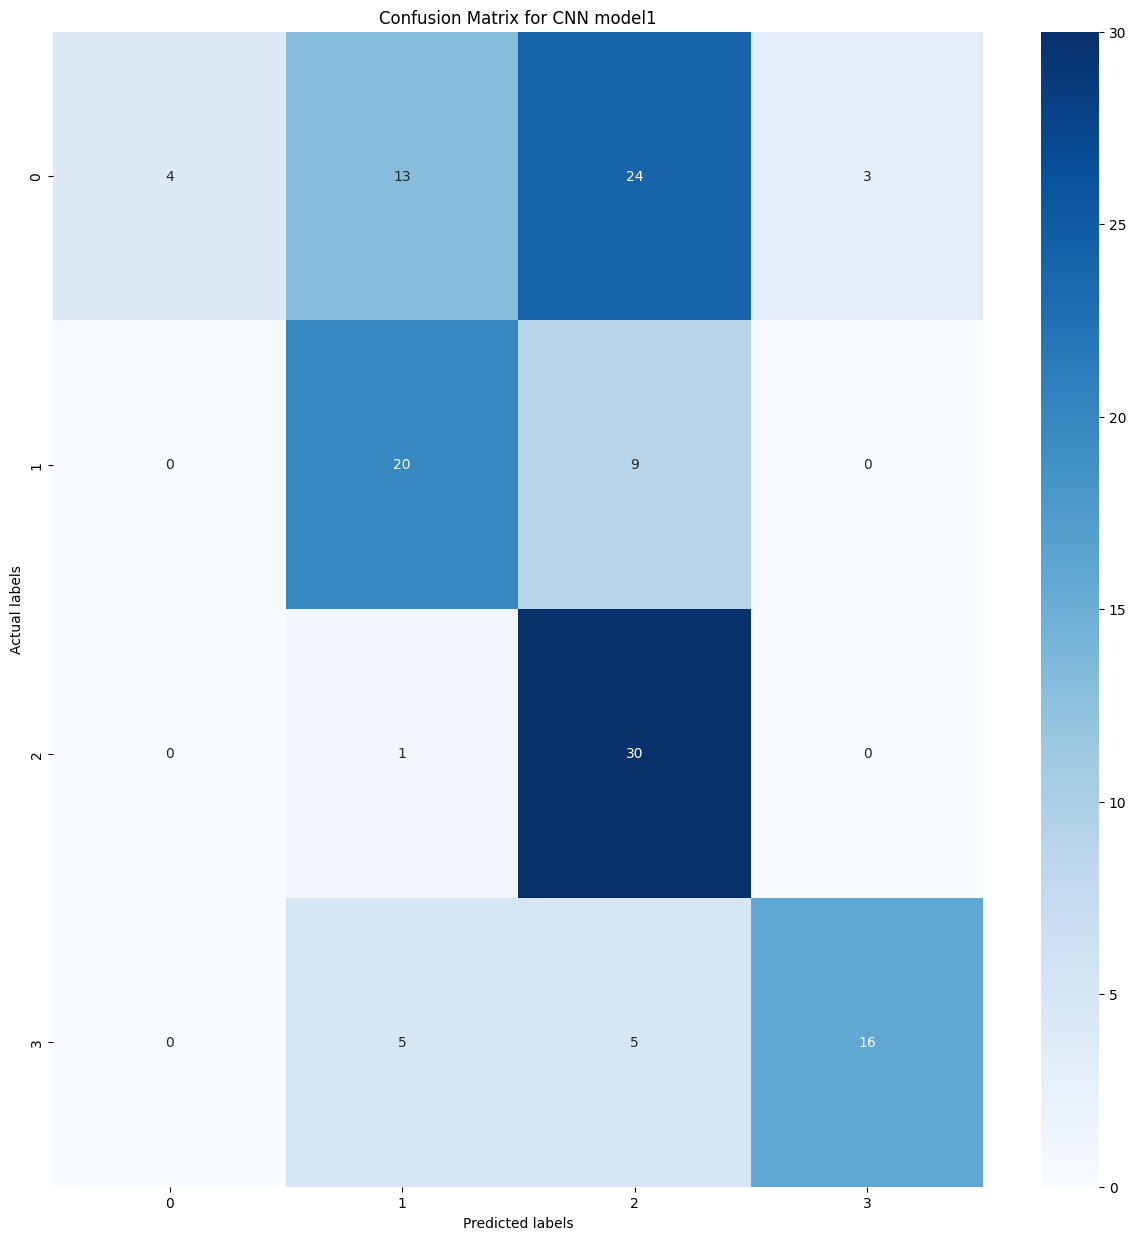

In [125]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix for CNN model1")

1/1 [==============================] - 0s 100ms/step


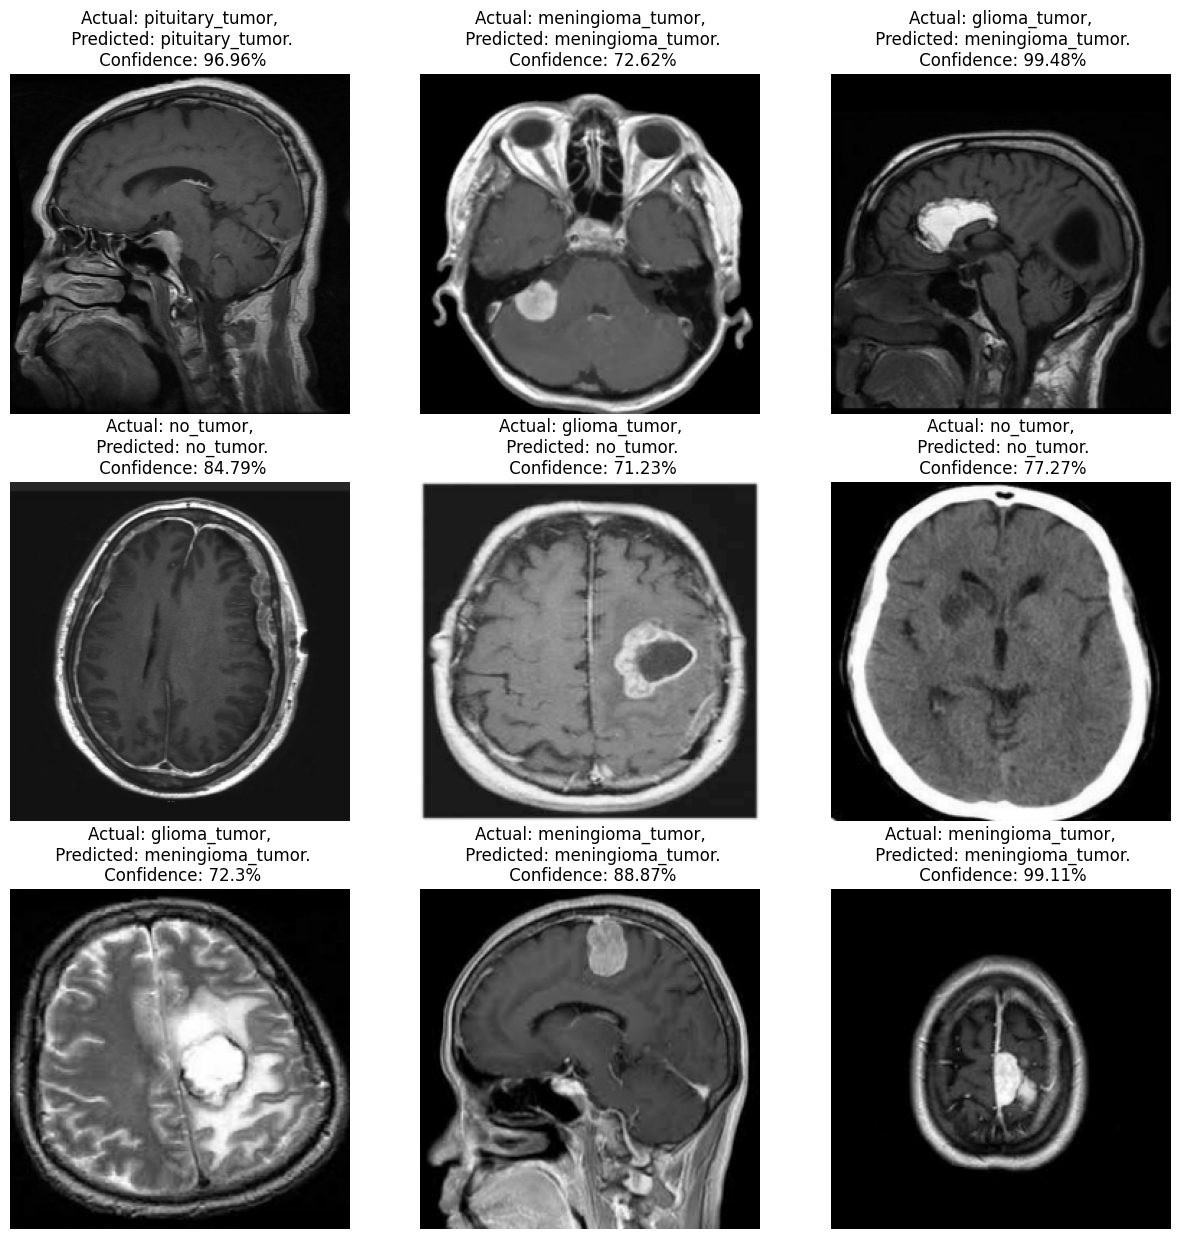

In [126]:
#Evaluate confidence of model on test set
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy(). astype("uint8"))
        
        predicted_class, confidence = predict(model4, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Conclusion

In [127]:
#Summary of Evaluation results
dic = [
    {"Type": "CNN 1", "Train_Accuracy": train_scores[1],"Validation_Accuracy": val_scores[1],"Test_Accuracy": scores[1], "Train_loss": train_scores[0], "Validation_loss": val_scores[0], "Test_loss": scores[0]},
    {"Type": "CNN 2", "Train_Accuracy": train_scores2[1],"Validation_Accuracy": val_scores2[1],"Test_Accuracy": scores2[1], "Train_loss": train_scores2[0], "Validation_loss": val_scores2[0], "Test_loss": scores2[0]},
    {"Type": "CNN 3", "Train_Accuracy": train_scores3[1],"Validation_Accuracy": val_scores3[1],"Test_Accuracy": scores3[1], "Train_loss": train_scores3[0], "Validation_loss": val_scores3[0], "Test_loss": scores3[0]},
    {"Type": "CNN 4", "Train_Accuracy": train_scores4[1],"Validation_Accuracy": val_scores4[1],"Test_Accuracy": scores4[1], "Train_loss": train_scores4[0], "Validation_loss": val_scores4[0], "Test_loss": scores[0]},  
]

table_summary = pd.DataFrame(dic)
table_summary

Type  Train_Accuracy  Validation_Accuracy  Test_Accuracy  Train_loss   
0  CNN 1        0.866609             0.868056       0.532995    0.340729  \
1  CNN 2        0.868352             0.890625       0.591371    0.362849   
2  CNN 3        0.860070             0.857639       0.614213    0.373434   
3  CNN 4        0.846556             0.866319       0.545685    0.438328   

   Validation_loss  Test_loss  
0         0.330044   2.661870  
1         0.330834   1.929281  
2         0.354774   2.741994  
3         0.406294   2.661870

In [128]:
#plt.figure()
#table_summary.plot(kind='bar', labels=['CNN1','CNN2','CNN3','CNN4'])
#plt.subplot(1,2,1)
fig = px.bar(table_summary, x='Type',
             y=['Train_loss','Validation_loss','Test_loss'],
             barmode='group',
             text_auto=True,
             labels={"value": "Loss"},
             title="Loss values for each model"
             )

#plt.subplot(1,2,2)
fig1 = px.bar(table_summary, x='Type',
              y=['Train_Accuracy','Validation_Accuracy','Test_Accuracy'], 
              barmode='group', 
              text_auto=True,
              labels={"value": "Accuracy"},
              title="Accuracy values for each model"
              )
#plt.legend()
fig.show()
fig1.show()